In [1]:
import matplotlib.pyplot as plt
from transmit import *
%matplotlib inline

## Setup OFDM system

In [2]:
# OFDM system setup:
test = OFDM
test.N, test.prefix_no, test.fs, test.repeat, test.gap_second = 2048, 256, 44100, 10, 0
test.__init__(test, test.N, test.prefix_no, test.fs, test.repeat, test.gap_second)

# File for transfer
filename = "test_files/shakespeare.txt"

# print the default seed for checking
print("The default seed is set to:", test.seed)

The default seed is set to: 2021


## Generate Known OFDM symbols 

In [3]:
# Generate the random symbols with the specific seed
random_symbols = test.generate_random_symbols_seeds(test)
known_frame, known_frames = test.generate_known_OFDM(test, random_symbols) 

In [4]:
chirp, inv_chirp = test.define_chirp(test)

## Generate transmitting signal with file 

Total length of the signal is: 1815552


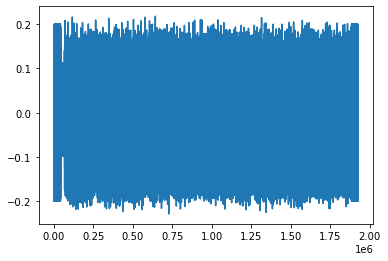

In [5]:
# Generate the data OFDM frames
data_frames, carrier_indices, bits_tran = test.data_add_pilots(test, "test_files/shakespeare.txt")
data_frames_len = len(data_frames)
print("Total length of the signal is:", data_frames_len)

# Combine to get the overall tx signals
tx_signal = test.tx_waveform_data_pilot(test, known_frames, chirp, data_frames)
plt.plot(tx_signal)
sf.write('transmit.wav', tx_signal, test.fs)

## Record and load the record file 

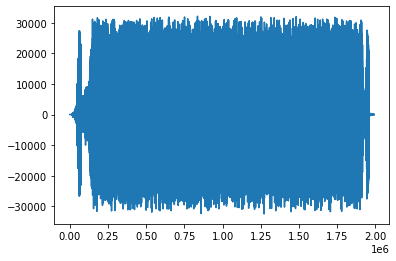

In [6]:
rx_signal = test.real_channel_response_file(test, "sound_files/Rec8.m4a")
plt.plot(rx_signal)

## Use matched filter to determine the chirp location

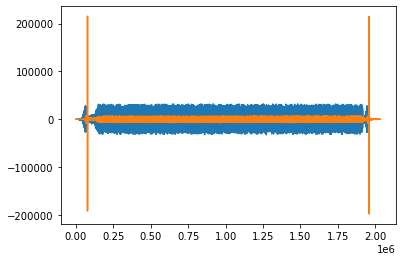

In [7]:
convolution, peak_index1, peak_index2 = test.matched_filter_double(test, rx_signal, inv_chirp)
plt.plot(rx_signal, label='channel op')
plt.plot(convolution/100, label='convolution')
plt.show()

## Measure the channel response with manual selected offset:

In [8]:
split_frame, avg_frame, start_refined = test.process_transmission_pilot(test, rx_signal, peak_index1, offset=20)

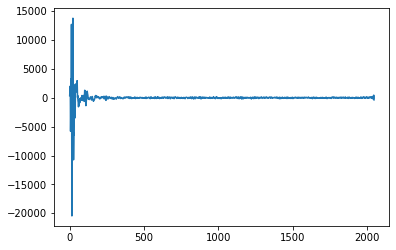

In [9]:
channel_freq_response, channel_imp_response = test.estimate_channel_response_pilot(test, avg_frame, known_frame)
plt.plot(channel_imp_response)

## Retrieve the transmitted informations

1. Manually select the offset 

In [10]:
data_begin = peak_index1 + len(known_frames) + test.gap # include gap

rx_data_full = rx_signal[data_begin:data_begin+len(data_frames)]
rx_data_frames = np.split(rx_data_full, len(rx_data_full)/(test.N+test.prefix_no))

rx_just_data_corrected, rx_just_pilots_corrected, bits_rec = test.data_remove_pilots_correct_phase(test, rx_data_frames, carrier_indices, channel_freq_response, filename='new.txt')

bitstr written to  new.txt


In [11]:
error_rate(bits_tran, bits_rec)

0.015045080880403076

2. Automatic fine tuning:


In [24]:
best_offset, best_score, bits_rec, best_imp_response = test.fine_tuning_pilot(test, rx_signal, peak_index1, known_frame, carrier_indices, data_frames_len=data_frames_len, find_range=30, offset=0, filename="New1.txt")

index and score are: -15 5.005731243329258
index and score are: -14 5.302351521063645
index and score are: -13 5.489994739146484
index and score are: -12 5.897369529214489
index and score are: -11 6.118100747443037
index and score are: -10 6.657564668655985
index and score are: -9 7.804583269343008
index and score are: -8 9.154081240580288
index and score are: -7 10.40664407596631
index and score are: -6 11.46514625617048
index and score are: -5 12.04552919515131
index and score are: -4 12.468808023874281
index and score are: -3 13.63624388935837
index and score are: -2 14.9332406222302
index and score are: -1 16.107552910983426
index and score are: 0 16.79599373374614
index and score are: 1 17.471098831630833
index and score are: 2 18.947328330024227
index and score are: 3 19.3516394995943
index and score are: 4 19.93932078915628
index and score are: 5 21.403577350102534
index and score are: 6 22.322100824472614
index and score are: 7 22.19042238128696
index and score are: 8 22.682476

17 23.283847679041077
BER: 0.013013789445770352


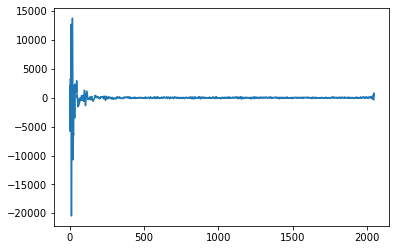

In [25]:
print(best_offset, best_score)
plt.plot(best_imp_response)
print("BER:",error_rate(bits_tran, bits_rec))